In [4]:
### Imports and Initial Model Setup ###
import time
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import jacobian, hessian
import pandas as pd
### ODE system ###
from scipy.integrate import solve_ivp
import sys
sys.path.append('lib/')

### Data and parameter imports ###
df_par = pd.read_excel('parameters/parameters.xlsx',sheet_name='py') # Excel file with parameters for easy review and modification
df_data = pd.read_excel('data/Murine Data.xlsx', sheet_name='Lung Tissue') # Load murine homogenized lung data

df_Maggie1 = pd.read_excel('data/MaggieModel.xlsx') #Maggie's Type I IFN model

# Function evaluation wrapper
def evalModel(funx, p, y0, t_span, state_labels, 
              t_eval=None, p_fit=None, p_fit_labels=None, state_corrections=None, ode_opts={'method': 'LSODA', 'rtol': 1e-2, 'atol': 1e-3}, best_parameters=None):
    
    state_history = StateHistory(y0)
    p_local = p.copy()

    # Update parameters if p_fit is provided
    if p_fit is not None:
        try:
            normal_p_fit = dict(zip(p_fit_labels, 10**p_fit))
        except:
            normal_p_fit = {p_fit_labels, 10**p_fit}
        for key, val in normal_p_fit.items():
            p_local[key] = val
            
    if best_parameters is not None:
        try:
            unpacked_best_parameters = dict(zip(best_parameters.labels, best_parameters['best']))
        except:
            unpacked_best_parameters = {best_parameters.labels, best_parameters['best']}
    
        for key, val in unpacked_best_parameters.items():
            p_local[key] = val

    # Reset start_time before each solve_ivp call
    global start_time 
    start_time = None
    try:
        
        # Use ode_opts to unpack options
        sol = solve_ivp(funx, t_span, y0, t_eval=t_eval, 
                        args=(p_local, state_labels, state_history), **ode_opts)

    except TimeoutError:
        print('Timeout error in ODE solver.')
        return None
    except RuntimeError:
        print('Runtime error in ODE solver.')
        return None

    # Use a comprehension to apply the operations
    if state_corrections is not None:
        for state, correction in state_corrections.items():
            sol.y[state_labels.index(state),:] += correction
    sol.y = sol.y.clip(min=1.0)

    return sol

### Function definitions ###
def errorfxn(p_fit, funx, p_fit_labels, p, y0, data, fit_choice, state_labels, t_span, state_corrections, ode_opts=None, best_parameters=None):
    
    t_eval = data['Time'].unique()
    sol = evalModel(funx, p, y0, t_span, state_labels, t_eval=t_eval, p_fit=p_fit, p_fit_labels=p_fit_labels, state_corrections=state_corrections, ode_opts=ode_opts, best_parameters=best_parameters)
    if sol is None: return np.inf # check that the solution is stable

    data_labels = data.columns[0:]
    data_idx = np.where(np.isin(data_labels, fit_choice))[0]
    idx = np.insert(data_idx, 0, [0,1]) # Prepend indexes 0 and 1 for Time and SampleID
    data_2d = data.iloc[:,idx] # Select only data for fitting, plus Time and SampleID
    data_2d = data_2d.set_index('Time') #Make Time the index
    ode_idx = np.where(np.isin(state_labels, fit_choice))[0] # Find where 'data to fit' occurs in ODE solutions's labels
    ode_labels = [state_labels[i] for i in ode_idx] # Create column labels
    x = sol.y[ode_idx,:].T # Filter to states which are compared to data
    x = np.log10(x, dtype='float32') # Filter to states which are compared to data
    df = pd.DataFrame(x, columns=ode_labels, index=sol.t)  # Turn the solution into a dataframe

    Sampled = data_2d.groupby('SampleID') #Group data by Sample ID
    Sampled = [g.drop('SampleID', axis=1) for _, g in Sampled] # Drop the Sample ID column from each group
    SSE = [(g - df)**2 for g in Sampled] # Find the SSE between the data and the ODE solution for every group

    # SSE data frame has [Time] rows, [State] columns, and [Replicate] pages
    SSE = pd.concat(SSE, axis=1).sum(axis=1) # Sum the SSE across the replicate dimension
    SSE = SSE.sum(axis=0) # Sum the SSE across the time dimension
    cost = SSE.sum(axis=0) # Sum the SSE across the state dimension
    
    # Considering data_2d as the 2D DataFrame prepared earlier
    #data_slice = data_2d.drop(['SampleID'], axis=1) # Removing SampleID
    
    # Remove anywhere Time is 0, since these points are used for initial conditions
    #data_slice = data_slice[data_slice.index != 0]
    #n = data_slice.count().sum() # Count the number of non-NaN observations
    #sigma_sq = cost / n # Calculate the variance of the errors
    #log_likelihood_value = log_likelihood(cost, n, sigma_sq) # log-likelihood
    
    # Excluding initial conditions from the model and data at this time
    #AIC_value = AIC(p_fit, log_likelihood_value) # Calculate the Akaike Information Criterion
    #BIC_value = BIC(p_fit, log_likelihood_value) # Calculate the Bayesian Information Criterion
    #AICc_value = AICc(p_fit, log_likelihood_value) # Calculate the Corrected Akaike Information Criterion 
        
    return cost

#  AIC given the number of fit parameters and log likelihood
def AIC(p_fit, log_likelihood_value):
    AIC = 2 * len(p_fit) - 2 * log_likelihood_value
    return AIC

#  Corrected AIC given the number of fit parameters and log likelihood
def AICc(p_fit, log_likelihood_value):
    AICc = 2 * len(p_fit) - 2 * log_likelihood_value / (len(p_fit))
    return AICc

#  Bayesian Information Criterion given the number of fit parameters and log likelihood
def BIC(p_fit, log_likelihood_value):
    BIC = 2 * len(p_fit) * np.log(len(p_fit)) - 2 * log_likelihood_value
    return BIC

#  cumulative auc for each state of ODE system solution
def cauc(time, sol):
    
    dt = np.diff(time)
    # For each state, calculate the cumulative AUC
    cumulative_auc = np.zeros_like(sol)
    for i in range(len(sol)):
        cumulative_auc[i][1:] = np.cumsum((sol[i][:-1] + sol[i][1:]) / 2 * dt)
    return cumulative_auc

# log likelihood of a parameter set
def log_likelihood(sse, n, sigma_sq):
    constant_term = -n/2 * np.log(2 * np.pi)
    variance_term = -n/2 * np.log(sigma_sq)
    sse_term = -sse / (2 * sigma_sq)
    return constant_term + variance_term + sse_term

# Define functions in Autograd to determine the jacobian and hessian of the errorfxn for later use by scipy's minimize.
jacobian_errorfxn = jacobian(errorfxn)
hessian_errorfxn = hessian(errorfxn)

# Convert the ArrayBox type to numpy array for compatibility with scipy's minimize
jacobian_errorfxn = np.array(jacobian_errorfxn)
hessian_errorfxn = np.array(hessian_errorfxn)

In [5]:
### Literature Models ###
def Maggie_Model(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))
    
    # Define delays
    # Only two delays are considered based on the new understanding
    delays = [
        ('tau_1', 'FB', 'FB_tau_1'),  # corresponds to Z(5,1) in MATLAB
        ('tau_2', 'CFB', 'CFB_tau_2')   # corresponds to Z(6,2) in MATLAB
    ]
    
    # Create delayed variables
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t - p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    # ODE system (Model 1)
    dS = -p['beta'] * s['S'] * s['V']
    dE = p['beta'] * s['S'] * s['V'] - p['k'] * s['E']
    dI = p['k'] * s['E'] - p['delta'] * s['I'] - p['psi'] * s['I'] * (s['Total_T'] - p['E_star']) / (s['I'] + p['mI'])
    dV = p['p'] * s['I'] - p['c'] * s['V']
    dFB = p['s'] * s['I'] + p['g'] * s['CFB'] - s['FB'] * (p['alpha'] + p['omega'] * (s['Total_T'] - p['E_star']))
    dCFB = p['sigma'] * s_tau['FB_tau_1'] - p['lambda'] * s_tau['CFB_tau_2'] if t<7 else 0 #TODO fix recurrent CFB spike
    dTotal_T = p['rho'] * (1 - s['Total_T'] / p['E_star']) + p['mu'] * s['L'] 
    dL = p['eta'] * s['L'] * s['I'] / (p['mE'] + s['I']) - p['mu'] * s['L']

    return [dS, dE, dI, dV, dFB, dCFB, dTotal_T, dL]
def Maggie_Model2A(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))
    delays = [('tau_1', 'FB', 'FB_tau_1')]
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t - p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    # ODE system (Model 1)
    dS = -p['beta'] * s['S'] * s['V']
    dE = p['beta'] * s['S'] * s['V'] - p['k'] * s['E']
    dI = p['k'] * s['E'] - p['delta'] * s['I'] - p['psi'] * s['I'] * (s['Total_T'] - p['E_star']) / (s['I'] + p['mI'])
    dV = p['p'] * s['I'] - p['c'] * s['V']
    dFB = p['s'] * s['I'] + p['g'] * s['CFB'] - s['FB'] * (p['alpha'] + p['omega'] * (s['Total_T'] - p['E_star']))
    dCFB = p['sigma'] * s_tau['FB_tau_1'] - p['lambda'] * s['CFB'] #if t<7 else 0 #TODO fix recurrent CFB spike
    dTotal_T = p['rho'] * (1 - s['Total_T'] / p['E_star']) + p['mu'] * s['L'] 
    dL = p['eta'] * s['L'] * s['I'] / (p['mE'] + s['I']) - p['mu'] * s['L']

    dydt = [dS, dE, dI, dV, dFB, dCFB, dTotal_T, dL]
    return dydt
def Maggie_Model2B(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))
    
    # Define delays
    # Only two delays are considered based on the new understanding
    delays = [
        ('tau_1', 'FB', 'FB_tau_1'),  # corresponds to Z(5,1) in MATLAB
        ('tau_2', 'CFB', 'CFB_tau_2')   # corresponds to Z(6,2) in MATLAB
    ]
    
    # Create delayed variables
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t - p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    # ODE system (Model 1)
    dS = -p['beta'] * s['S'] * s['V']
    dE = p['beta'] * s['S'] * s['V'] - p['k'] * s['E']
    dI = p['k'] * s['E'] - p['delta'] * s['I'] - p['psi'] * s['I'] * (s['Total_T'] - p['E_star']) / (s['I'] + p['mI'])
    dV = p['p'] * s['I'] - p['c'] * s['V']
    dFB = p['s'] * s['I'] + p['g'] * s['CFB'] - s['FB'] * (p['alpha'] + p['omega'] * (s['Total_T'] - p['E_star']))
    dCFB = p['sigma'] * s_tau['FB_tau_1'] - p['lambda'] * s_tau['CFB_tau_2'] if t<7 else 0 #TODO fix recurrent CFB spike
    dTotal_T = p['rho'] * (1 - s['Total_T'] / p['E_star']) + p['mu'] * s['L'] 
    dL = p['eta'] * s['L'] * s['I'] / (p['mE'] + s['I']) - p['mu'] * s['L']

    dydt = [dS, dE, dI, dV, dFB, dCFB, dTotal_T, dL]
    return dydt
def Maggie_Model2C(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))
    
    # Define delays
    # Only two delays are considered based on the new understanding
    delays = [
        ('tau_1', 'FB', 'FB_tau_1')  # corresponds to Z(5,1) in MATLAB
    ]
    
    # Create delayed variables
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t - p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    # ODE system (Model 1)
    dS = -p['beta'] * s['S'] * s['V']
    dE = p['beta'] * s['S'] * s['V'] - p['k'] * s['E']
    dI = p['k'] * s['E'] - p['delta'] * s['I'] - p['psi'] * s['I'] * (s['Total_T'] - p['E_star']) / (s['I'] + p['mI'])
    dV = p['p'] * s['I'] - p['c'] * s['V']
    dFB = p['s'] * s['I'] + p['g'] * s['CFB'] - s['FB'] * (p['alpha'] + p['omega'] * (s['Total_T'] - p['E_star']))
    dCFB = p['sigma'] * s_tau['FB_tau_1'] - p['lambda'] * s['CFB'] - p['rhot'] * (s['Total_T'] - p['E_star']) #if t<7 else 0 #TODO fix recurrent CFB spike
    dTotal_T = p['rho'] * (1 - s['Total_T'] / p['E_star']) + p['mu'] * s['L'] 
    dL = p['eta'] * s['L'] * s['I'] / (p['mE'] + s['I']) - p['mu'] * s['L']
    dydt = [dS, dE, dI, dV, dFB, dCFB, dTotal_T, dL]
    return dydt
def Maggie_Model2D(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))
    
    # Define delays
    # Only two delays are considered based on the new understanding
    delays = [
        ('tau_1', 'FB', 'FB_tau_1'),
        ('tau_2', 'CFB', 'CFB_tau_2')# corresponds to Z(5,1) in MATLAB
    ]
    
    # Create delayed variables
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t - p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    # ODE system (Model 1)
    dS = -p['beta'] * s['S'] * s['V']
    dE = p['beta'] * s['S'] * s['V'] - p['k'] * s['E']
    dI = p['k'] * s['E'] - p['delta'] * s['I'] - p['psi'] * s['I'] * (s['Total_T'] - p['E_star']) / (s['I'] + p['mI'])
    dV = p['p'] * s['I'] - p['c'] * s['V']
    dFB = p['s'] * s['I'] + p['g'] * s['CFB'] - s['FB'] * (p['alpha'] + p['omega'] * (s['Total_T'] - p['E_star']))
    dCFB = p['sigma'] * s_tau['FB_tau_1'] - p['lambda'] * s_tau['CFB_tau_2'] * (s['Total_T'] - p['E_star']) #if t<7 else 0 #TODO fix recurrent CFB spike
    dTotal_T = p['rho'] * (1 - s['Total_T'] / p['E_star']) + p['mu'] * s['L'] 
    dL = p['eta'] * s['L'] * s['I'] / (p['mE'] + s['I']) - p['mu'] * s['L']

    dydt = [dS, dE, dI, dV, dFB, dCFB, dTotal_T, dL]
    return dydt
def Maggie_ModelH1(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    # Create a dict from states in s and values of y
    s = dict(zip(state_labels, y))

    # Define delays
    # Only two delays are considered based on the new understanding
    delays = [
        ('tau_1', 'FB', 'FB_tau_1'),  # corresponds to Z(5,1) in MATLAB
        ('tau_2', 'CFB', 'CFB_tau_2')   # corresponds to Z(6,2) in MATLAB
    ]

    # Create delayed variables
    s_tau = {var_name: LinearDelay(state_history, state_labels.index(state), t - p[tau]) if t >= p[tau] else 0 for tau, state, var_name in delays}

    # ODE system (Model 1)
    dS = -p['beta'] * s['S'] * s['V']
    dE = p['beta'] * s['S'] * s['V'] - p['k'] * s['E']
    dI = p['k'] * s['E'] - p['delta'] * s['I'] - p['psi'] * s['I'] * (s['Total_T'] - p['E_star']) / (s['I'] + p['mI'])
    dV = p['p'] * s['I'] - p['c'] * s['V']
    dFB = p['s'] * s['I'] + 0*p['g'] * s['CFB'] - s['FB'] * (p['alpha'] + p['omega'] * (s['Total_T'] - p['E_star']))
    dCFB = 0#p['sigma'] * s_tau['FB_tau_1'] - p['lambda'] * s_tau['CFB_tau_2'] if t<7 else 0 #TODO fix recurrent CFB spike
    dTotal_T = p['rho'] * (1 - s['Total_T'] / p['E_star']) + p['mu'] * s['L'] 
    dL = p['eta'] * s['L'] * s['I'] / (p['mE'] + s['I']) - p['mu'] * s['L']

    dydt = [dS, dE, dI, dV, dFB, dCFB, dTotal_T, dL]
    return dydt

p1 = {
    'beta': 3.2216e-06, 'delta': 0.8261, 'k': 8.5008, 'p': 7.4547, 'c': 17.6037,
    'psi': 0.1575, 'mu': 2.236, 'eta': 5.005, 'mI': 1000, 's': 9.8540e-06, 'g': 0.00189,
    'alpha': 1.5, 'omega': 2.4e-06, 'sigma': 1000, 'E_star': 68000, 'lambda': 4,
    'phi': 5.838, 'rho': 244335, 'iota': 7, 'kappa': 187951, 'mE': 22500,
    'tau_1': 1.0, 'tau_2': 0.6
}

p2 = {
    'beta': 3.2216e-06, 'k': 8.5008, 'delta': 0.8261, 'psi': 0.1575, 'mI': 1000,
    'p': 7.4547, 'c': 17.6037,
    's': 9.8540e-06, 'g': 0.00189, 'alpha': 1.5, 'omega': 2.4e-06, 
    'sigma': 1000, 'lambda': 4, 'tau_1': 2, 'tau_2': 0.8,
    'rho': 244335, 'E_star': 421899,
    'eta': 5.005, 'mu': 2.236, 'mE': 22500
}

# Initial conditions and time span
initial_conditions_Maggie = np.array([10**7, 75, 0, 0, 0, 0, 68000, 10])
t_span_Maggie = [0, 12.5]
t_eval_Maggie = np.linspace(0, 12.5, 100)
state_labels_Maggie = ['S', 'E', 'I', 'V', 'FB', 'CFB', 'Total_T', 'L']

ode_opts={'method': 'LSODA', 'rtol': 1e-4, 'atol': 1e-4, 'min_step':1e-5, 'max_step':1e-1}

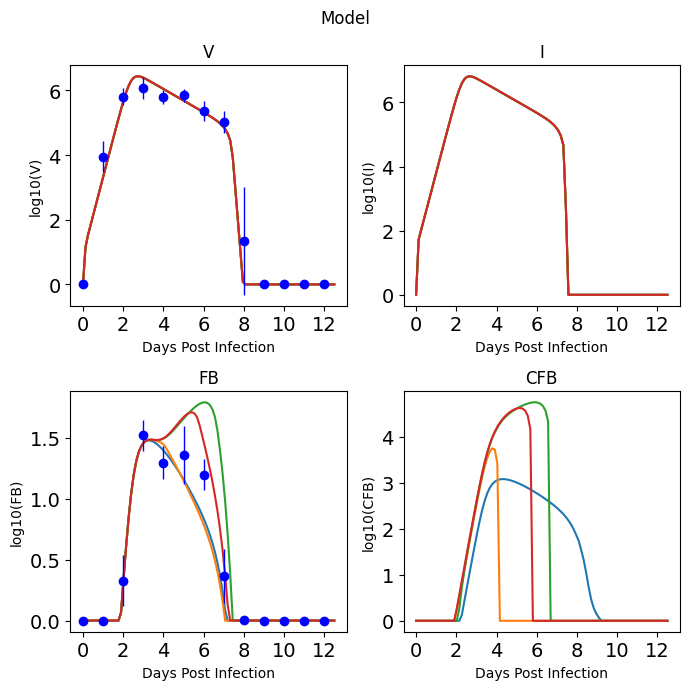

In [7]:

### Maggie model IFN+ Cell clearance hypotheses ###
p2A = p1.copy() # lambda * CFB
p2A.update({'lambda': 25})

p2B = p1.copy()
p2B.update({'lambda': 25})

p2C = p1.copy()
p2C.update({'lambda': 0.1, 'rhot': 0.5})

p2D = p1.copy()
p2D.update({'lambda': 0.0001, 'tau_2': 0.6})

sol_list = []

state_history_Maggie2A = StateHistory(initial_conditions_Maggie)
sol_Maggie_2A = solve_ivp(Maggie_Model2A, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie, 
                  args=(p2A, state_labels_Maggie, state_history_Maggie2A), **ode_opts)

sol_Maggie_2A.y = sol_Maggie_2A.y.clip(min=1.0)
sol_list.append(sol_Maggie_2A)

state_history_Maggie2B = StateHistory(initial_conditions_Maggie)
sol_Maggie_2B = solve_ivp(Maggie_Model2B, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie,
                          args=(p2B, state_labels_Maggie, state_history_Maggie2B), **ode_opts)

sol_Maggie_2B.y = sol_Maggie_2B.y.clip(min=1.0)
sol_list.append(sol_Maggie_2B)

state_history_Maggie2C = StateHistory(initial_conditions_Maggie)
sol_Maggie_2C = solve_ivp(Maggie_Model2C, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie,
                          args=(p2C, state_labels_Maggie, state_history_Maggie2C), **ode_opts)

sol_Maggie_2C.y = sol_Maggie_2C.y.clip(min=1.0)
sol_list.append(sol_Maggie_2C)

state_history_Maggie2D = StateHistory(initial_conditions_Maggie)
sol_Maggie_2D = solve_ivp(Maggie_Model2D, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie,
                          args=(p2D, state_labels_Maggie, state_history_Maggie2D), **ode_opts)

sol_Maggie_2D.y = sol_Maggie_2D.y.clip(min=1.0)
sol_list.append(sol_Maggie_2D)

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sol_labels = ['2A', '2B', '2C', '2D']

### Plotting setup ### 
# Define a dictionary with states and corresponding corrections
state_corrections = {
    'IL6': 9.39,
    'GMCSF': 10.28,
    'TNFA': 8.37,
    'MI': 11499,
    'N': 250034,
    'Total_T': 421899,
}
ylims_dict = {'Total_T': [4.5, 7.0]} # Dictionary of [model state string][floor, ceiling] for plotting ylim changes

# Plot the result
fig, axs = ModelPlotting(sol_list, t_span_Maggie, include=['V', 'I', 'FB', 'CFB'], data=df_data, states=state_labels_Maggie, 
                         figsize=(7, 7), title='Model', color_dict=color_list, sol_labels=sol_labels, ylims_dict=ylims_dict)


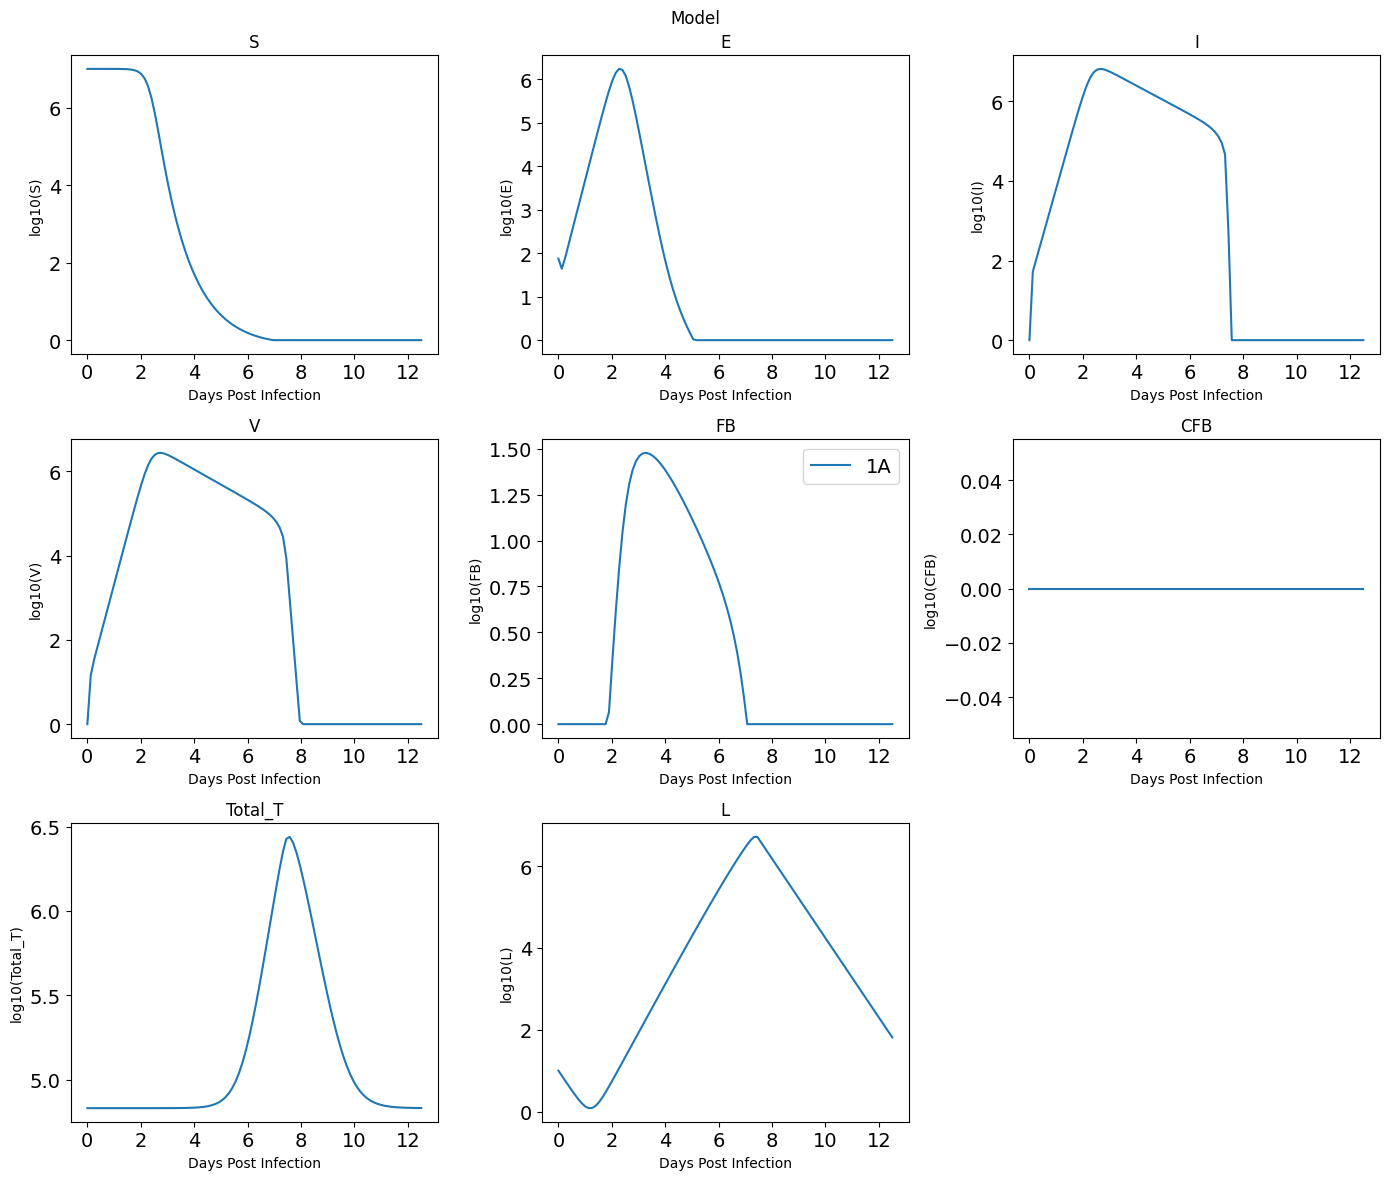

In [8]:

### Maggie model IFN clearance hypotheses ###
pF1B = p1.copy()
pF1B.update({'alpha' : 1.5})
pF1B.update({'omega': 0.0})
pF1B.update({'g': 0.0})

state_history_Maggie = StateHistory(initial_conditions_Maggie)
sol_Maggie = solve_ivp(Maggie_ModelH1, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie, 
                  args=(p1, state_labels_Maggie, state_history_Maggie), **ode_opts)

sol_Maggie.y = sol_Maggie.y.clip(min=1.0)

sol_Maggie_F1B = solve_ivp(Maggie_ModelH1, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie, 
                  args=(pF1B, state_labels_Maggie, state_history_Maggie), **ode_opts)
sol_Maggie_F1B.y = sol_Maggie_F1B.y.clip(min=1.0)

sol_list = []
sol_list.append(sol_Maggie)
#sol_list.append(sol_Maggie_F1B)

color_list = ['#1f77b4', '#ff7f0e']

sol_labels = ['1A', '1B']

# Plot the result
fig, axs = ModelPlotting(sol_list, t_span_Maggie, include=state_labels_Maggie, states=state_labels_Maggie, 
                         figsize=(14, 12), title='Model', color_dict=color_list, sol_labels=sol_labels, ylims_dict=ylims_dict)

In [ ]:
### Sensitivity Analysis ###
import matplotlib.cm as cm
from datetime import datetime
import os

lowfac = 0.1
highfac = 10
log_space_sampling = True  # Set to True for log space sampling
log_up_down = 2  # Number of logs up and down

# Create a new subfolder in `/sensitivity/` with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_path = f'sensitivity/{timestamp}'
os.makedirs(folder_path, exist_ok=True)

# Matplotlib's colormap
norm = plt.Normalize(lowfac, highfac)
colormap = cm.cividis

all_pars = p1.items()

# Select only 'omega' and 'sigma'
#selected_pars = {key: value for key, value in all_pars if key in ['omega']}
# Select everything 
selected_pars = {key: value for key, value in all_pars}

# Loop through all parameters
for parameter, original_value in selected_pars.items():
    p_sens = p1.copy()  # Copy of parameter dictionary
    
    sol_list = []  # List to store solutions for different parameter values
    color_list = []  # List to store colors for different parameter values

    # Loop through parameter variations (±50% in 10 steps)
    if log_space_sampling:
        steps = np.logspace(-log_up_down, log_up_down, 50) * original_value
    else:
        steps = np.linspace(original_value * lowfac, original_value * highfac, 50)

    for value in steps:
        # Use the colormap
        color = colormap(norm(value / original_value))

        p_sens[parameter] = value
        state_history_Maggie = StateHistory(initial_conditions_Maggie)
        sol_Maggie = solve_ivp(Maggie_Model, t_span_Maggie, initial_conditions_Maggie, t_eval=t_eval_Maggie,
                               args=(p_sens, state_labels_Maggie, state_history_Maggie), **ode_opts)

        sol_Maggie.y = sol_Maggie.y.clip(min=1.0)
        # Store the solution and color for later plotting
        sol_list.append(sol_Maggie)
        color_list.append(color)

    # Plotting with ModelPlotting
    fig, axs = ModelPlotting(sol_list, t_span_Maggie, include=state_labels_Maggie, data=df_data,
                             states=state_labels_Maggie, figsize=(14, 12), title=(f"Sensitivity Analysis for {parameter}"), color_dict=color_list, comp=
                             ggie1)
    fig.tight_layout()
    fig.savefig(f"{folder_path}/{parameter}.png")
    plt.close(fig)